In [1]:
# import py7zr


# filename = 'sample_data/twitter-coronavirus-A-2020-05-30-00-12-35-c89f265b-13f4-49fa-93c1-8ceccfe15700.7z'

# # load some sample data
# with py7zr.SevenZipFile(filename, 'r') as z:
#     z.extractall()


In [2]:
import json
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import PCA
from sklearn.cluster import MiniBatchKMeans, DBSCAN
from sklearn.neighbors import NearestNeighbors
from nltk.stem import PorterStemmer
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import re


# load some sample data
filename = 'sample_data/twitter-coronavirus-A-2020-05-30-00-12-35-c89f265b-13f4-49fa-93c1-8ceccfe15700'
with open(filename, 'r') as f:
    data = json.loads('['+f.read().replace('}{','},{')+']')

# remove retweets
tweets = [tweet for tweet in data if 'retweeted_status' not in tweet]
# keep english language tweets only
tweets = [tweet for tweet in tweets if tweet['lang'] == 'en']


# seperate out just tweet text for simplicity
ttexts = [tweet['full_text'] for tweet in tweets]
# (probably unecessary) keep an id map: tweet text index --> tweet id
# id_map = {i: tweets[i]['id'] for i in range(len(tweets))}

# remove numbers
ttexts = [re.sub('[0-9]+', '', tweet) for tweet in ttexts]




In [3]:
# make stemmer to pass to vectorizer
stemmer = PorterStemmer()
analyzer = CountVectorizer().build_analyzer()

def stemmed_words(doc):
    return (stemmer.stem(w) for w in analyzer(doc))

# remove stop words, tokenize, stem
vectorizer = CountVectorizer(strip_accents='ascii', stop_words='english', analyzer=stemmed_words, min_df=5)
vtweets = vectorizer.fit_transform(ttexts)
vtweets.shape



(1528, 950)

In [4]:
vdf = pd.DataFrame(vtweets.toarray(), columns=sorted(vectorizer.vocabulary_.keys()))
vdf

,abc,abl,about,absolut,abus,accord,accus,across,act,action,...,would,write,wrong,wuhan,ye,year,york,you,your,youtub
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1523,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
1524,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1525,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
1526,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Text(0, 0.5, 'cumulative explained variance')

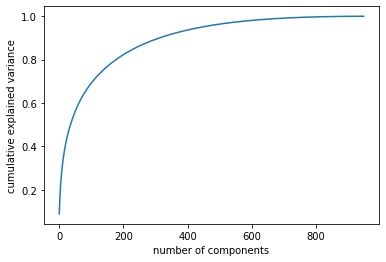

In [5]:
# draw pca graph
pca = PCA()
pca.fit(vdf)

plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance')

Text(0, 0.5, 'cumulative explained variance')

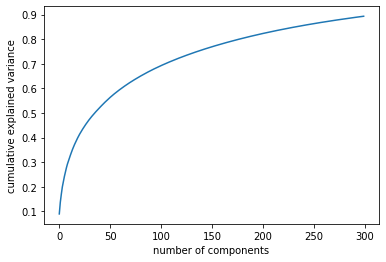

In [6]:
plt.plot(np.cumsum(pca.explained_variance_ratio_[:300]))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance')

In [7]:
# apply suitable dim reduciton: 300 pc
pca = PCA(300)
pctweets = pca.fit_transform(vdf)
pctweets.shape

(1528, 300)

In [8]:
# cluster
# cls = MiniBatchKMeans(n_clusters=5, random_state=0)
# cls.fit(pctweets)
# cls.labels_

In [9]:
# plot 1st 2 components
# reduce the features to 2D
# pca = PCA(2)
# reduced_features = pca.fit_transform(pctweets)

# # reduce the cluster centers to 2D
# reduced_cluster_centers = pca.transform(cls.cluster_centers_)

# plt.scatter(reduced_features[:,0], reduced_features[:,1], c=cls.predict(pctweets))
# plt.scatter(reduced_cluster_centers[:, 0], reduced_cluster_centers[:,1], marker='x', s=150, c='b')


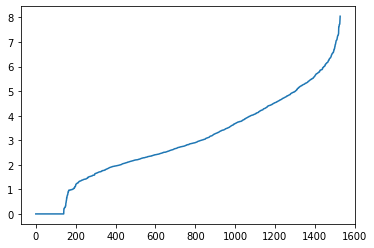

In [23]:
# cluster
# a paper on twitter clusttering with dbscan uses minSaples in a range of 10 to 60. I will try with 10, but it's a shot in the dark as I have no domain knowledge about what twitter text is like.
# one tutorial indicates that minSamples hould be greater than the dimensionality of the data, but with 300 features this seems absurd

# finding a good epsilon

# plt.scatter(reduced_features[:,0], reduced_features[:,1], c=cls.predict(pctweets))
# plt.scatter(reduced_cluster_centers[:, 0], reduced_cluster_centers[:,1], marker='x', s=150, c='b')
neighbors = NearestNeighbors(n_neighbors=10) # I'm using minSamples=10
neighbors_fit = neighbors.fit(pctweets)
distances, indices = neighbors_fit.kneighbors(pctweets)

distances = np.sort(distances, axis=0)
distances = distances[:,1]
plt.plot(distances)

In [19]:
# this plot doesn't look right. Why are there so many distances of 0? is this even possible?
# distances[:10]
# np.sum(vdf.duplicated())
#  there are nearly 100 duplicates after tokenizing the tweets. this would explain the previous plot
# why are there so many duplicates???

np.sum(pd.DataFrame(ttexts).duplicated())
# As far as I can tell, there are no duplicate tweets, but the vector repr of some must be identical


# according to the graph, a good eps would be 6.5

0

In [24]:
# cluster
cls = DBSCAN(eps=6.5, min_samples=10)
cls.fit(vdf)
cls.labels_

array([0, 0, 0, ..., 0, 0, 0])

0

In [12]:
# try detecting negative asian sentiment within each cluster